# Phase 5 Capstone Project
## Neural Style Transfer
### Authored by Trinity Gahagen
---
---

# Table of Contents

# Brief EDA
---

In [1]:
# Basic imports
import numpy as np
import os
import matplotlib.pyplot as plt
import re

# Image tool imports
from PIL import Image, ImageOps
import cv2

# Deep learning imports
import tensorflow as tf
import tensorflow_hub as hub
import h5py

In [3]:
CONTENT_DIRECTORY = "images/content/"
STYLES_DIRECTORY = "images/styles/"

In [4]:
# Look at the list of content images
content_names = os.listdir(CONTENT_DIRECTORY)
content_names

['beach.jpg',
 'bird_at_beach.jpg',
 'cat.jpg',
 'desert_1.jpg',
 'desert_2.jpg',
 'desert_3.jpg',
 'flower.jpg',
 'octopus.jpg',
 'person.jpg',
 'seashell.jpg',
 'sunset.jpg']

In [5]:
# Look at the list of style images
style_names = os.listdir(STYLES_DIRECTORY)
style_names

["at_the_water's_edge_.jpg",
 'chateau_noir_.jpg',
 'dance_hall_bellevue__obverse__.a.jpg',
 'el_rio_de_luz_(the_river_of_light)_.jpg',
 'flecks_of_foam_.jpg',
 'genesis_ii_.jpg',
 'glass_and_checkerboard_.jpg',
 'haystacks_in_brittany_.jpg',
 'keelmen_heaving_in_coals_by_moonlight_.jpg',
 'landscape_.jpg',
 'lumber_schooners_at_evening_on_penobscot_bay_.jpg',
 'melon_and_lemon_.jpg',
 'moonlight_.jpg',
 'new_york_.jpg',
 'place_du_carrousel,_paris_.jpg',
 'political_drama_.jpg',
 'red_path,_st._prex_.jpg',
 'salem_cove_.jpg',
 'seascape_(gravelines)_.jpg',
 'swiss_landscape_.jpg',
 'the_bend_in_the_road_.jpg',
 'the_evening_of_the_deluge_.jpg',
 'the_harvest_.jpg',
 'the_houses_of_parliament,_sunset_.jpg',
 'the_island_of_raguenez,_brittany_.jpg',
 'the_olive_orchard_.jpg',
 'the_peppermint_bottle_.jpg',
 'the_visit_-_couple_and_newcomer_.jpg',
 'the_watering_can_(emblems__the_garden)_.jpg',
 'two_poplars_in_the_alpilles_near_saint_-_remy_.jpg',
 'venice_.jpg',
 'weasels_at_play_.jpg'

In [6]:
# Create a list of paths for all images in each directory
style_paths = [os.path.join(STYLES_DIRECTORY, name) for name in style_names]
content_paths = [os.path.join(CONTENT_DIRECTORY, name) for name in content_names]

### How many images are in each folder?

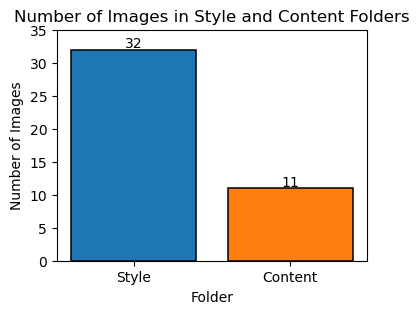

In [7]:
# List 
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x=[0, 1], height=[len(style_names), len(content_names)], lw=1.1, edgecolor='black', color=['tab:blue', 'tab:orange'])
ax.set_ylim(0, 35)
ax.annotate(len(style_names),
            xy=(0, len(style_names) + 0.025 * 35),
            va='center',
            ha='center')
ax.annotate(len(content_names),
            xy=(1, len(content_names) + 0.025 * 35),
            va='center',
            ha='center')
ax.set_xticks([0, 1], labels=['Style', 'Content'])
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images in Style and Content Folders')
ax.set_xlabel('Folder');

There are approximately 

In [8]:
example_styles = [Image.open(path) for path in style_paths]

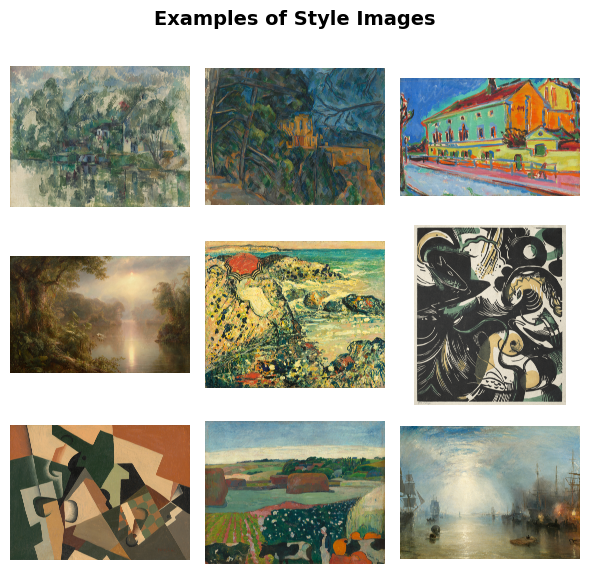

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.suptitle('Examples of Style Images', weight='bold', size=14)
for i in range(9):
    ax = axes[i // 3, i % 3]
    ax.set_axis_off()
    ax.imshow(example_styles[i])
plt.tight_layout();

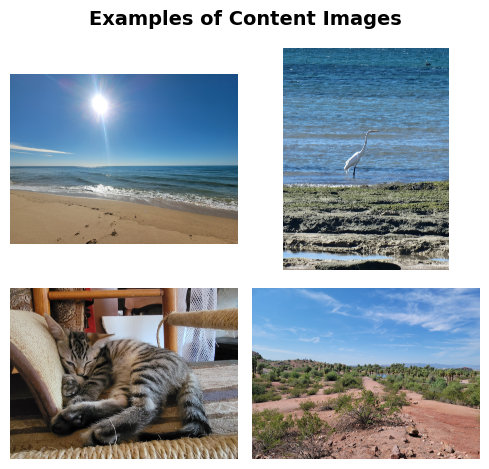

In [10]:
example_content = [ImageOps.exif_transpose(Image.open(path)) for path in content_paths]

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
fig.suptitle('Examples of Content Images', weight='bold', size=14)
for i in range(4):
    ax = axes[i // 2, i % 2]
    ax.set_axis_off()
    ax.imshow(example_content[i])
plt.tight_layout();

# Demonstrating Neural Style Transfer Using TensorflowHub

The following code snippet was copied and slightly adapted from [*this*](https://dev.to/chefgideon/unlocking-artistry-a-guide-to-neural-style-transfer-34g6) website, and will be used to demonstrate the general direction of this project.

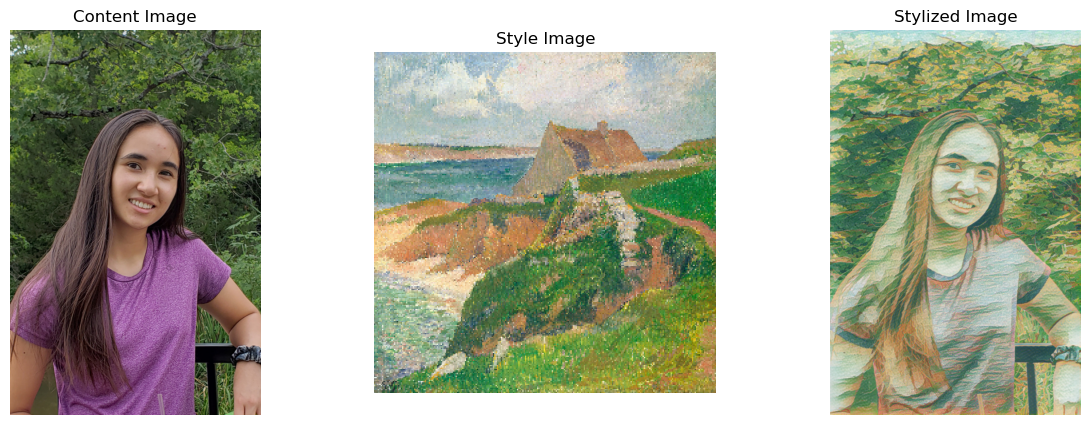

In [11]:
def preprocess_and_view_image(content_image_path, style_image_path, save_path=None):
    content_image = plt.imread(content_image_path)
    style_image = plt.imread(style_image_path)
    content_image = content_image.astype(np.float32)[np.newaxis, ...] / 255.
    style_image = style_image.astype(np.float32)[np.newaxis, ...] / 255.

    style_image = tf.image.resize(style_image, [256, 256])
    hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
    outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
    stylized_image = outputs[0]
    stylized_image_array = stylized_image.numpy()
    stylized_image_array = np.clip(stylized_image_array, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(content_image[0])
    plt.title('Content Image')
    plt.axis(False)
    plt.subplot(132)
    plt.imshow(style_image[0])
    plt.title('Style Image')
    plt.axis(False)
    plt.subplot(133)
    plt.imshow(stylized_image_array[0])
    plt.title('Stylized Image')
    plt.axis(False)
    plt.show()

random_content = content_paths[np.random.randint(0, 12)]
random_style = style_paths[np.random.randint(0, 30)]
preprocess_and_view_image(random_content, random_style, 'output_image.jpg')

While this method technically does the job, it doesn't really capture the style of the style image very well. It seemingly just creates a style-inspired filter and overlays it onto the original content image. Let's see how we can create a more refined combination of the two images.

# Creating a More Customized Architecture (Using VGG19)

According to Gatys et. al, the original creators of the neural style transfer algorithm, we can use a normalized version of the VGG-19 Convolutional Neural Network to create the stylized images. The authors mention that they

> normalized the network by scaling the weights such that the mean activation of each convolutional filter over images and positions is equal to one.

They also mention that

> replacing the maximum pooling operation by average pooling yields slightly more appealing results

In [26]:
# Load the pre-trained VGG-19 model, without the fully connected dense layers
vgg = tf.keras.applications.VGG19(include_top=False)

In [27]:
vgg.layers

[<InputLayer name=input_layer_6, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <Conv2D name=block3_conv4, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <Conv2D name=block4_conv4, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <Conv2D name=block5_conv4, built=True>,
 <MaxPooling2D name=block5_pool, built=True>]

# External Sources
---
L. A. Gatys, A. S. Ecker and M. Bethge, "Image Style Transfer Using Convolutional Neural Networks," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 2414-2423, doi: 10.1109/CVPR.2016.265. keywords: {Image reconstruction;Neural networks;Image representation;Semantics;Neuroscience;Feature extraction;Visualization},

https://www.tensorflow.org/tutorials/generative/style_transfer